In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [223]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm
import json
from collections import defaultdict
import os
import sys
import seaborn as sns
style = "fivethirtyeight"
#plt.style.use(style)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.rc('font', **{'size': 14, 'family': 'serif', 'serif': ['Computer Modern']})
mpl.rc('text', usetex=True)
#mpl.rc('text', usetex=False)

In [4]:
SAVE_LATEX = False
if SAVE_LATEX:
    mpl.use("pgf")
    params = {
        "pgf.texsystem": "pdflatex",
        'pgf.rcfonts': False,
    }
    mpl.rcParams.update(params)

In [5]:
from tollef_cleaner import Cleaner
cleaner = Cleaner()

In [121]:
# init neuralcoref class
from tollef_coref import Coref
params = {
    "greed": 0.53,
    "max_dist": 50,
    "max_dist_match": 200
}
coref = Coref(params, spacy_size="md")

Loading spacy model...
Added neuralcoref to pipeline!


In [6]:
datapath = "../../data/SENTIMENT_ANALYSIS"
store_path = "../../data/SENTIMENT_ANALYSIS/formatted/"

In [7]:
datasets = os.listdir(datapath)
datasets

['ACL14',
 'formatted',
 'SemEval2014Task4',
 'SemEval2017Task4',
 'SemEval2017Task5',
 'SentiHood']

In [8]:
valid_file_formats = [".raw", ".txt", ".xml.seg", ".json"]
MASK = "$T$"

In [9]:
def folder_path(folder):
    return os.path.join(datapath, folder)

def get_data(folder, name):
    return os.path.join(folder_path(folder), name)

def folder_files(folder):
    print(folder)
    all_files = os.listdir(folder_path(folder))
    train_data = []
    test_data = []
    for _file in all_files:
        if any(file_format in _file for file_format in valid_file_formats):
            file_path = get_data(folder, _file)
            if "test" in _file.lower():
                test_data.append(file_path)
            else:
                # catch trial, dev and other named datasets
                train_data.append(file_path)
    return {
        "test": test_data,
        "train": train_data
    }

In [10]:
s = "Dear $T$ , Gray Hoodies turned into Leather Jackets , '' Ay ! '' turned into '' Swag '' , u grew up , and we 've been here all the way . RT i u love Bieber â™¥\n"

cleaner.clean(s)

"Dear $T$ , Gray Hoodies turned into Leather Jackets , '' Ay '' turned into '' Swag '' , u grew up , and we 've been here all the way . RT i u love Bieber"

In [206]:
def simple_clean(text, entity, sent):
    #if isinstance(sent, float) or (isinstance(sent, str) and len(sent) > 2):
        # translate from "positive" to "1" etc.
    if isinstance(sent, float) or isinstance(sent, int) or len(sent) > 3:
        sent = translate_sentiment(sent)        
    
    text = cleaner.clean(text)
    entity = entity.strip()
    # check for masks, if not existing, replace entity with it.
    if not MASK in text:
        # attempt to split the entity and then replace it (e.g. Company PLC not matching due to only referrals from "Company")
        if len(entity.split()) > 1:
            for entity_part in entity.split():
                if entity_part in text:
                    text = text.replace(entity_part, MASK)
                    break
                    # do not allow short inreferrable entities, such as PLC
        else:
            text = text.replace(entity, MASK)
    
    return [cleaner.clean(text), entity, int(sent.strip())]

POS, NEU, NEG = "1", "0", "-1"
def translate_sentiment(sent):
    if isinstance(sent, int):
        return str(sent)
    
    if isinstance(sent, float):
        threshold = 0.45
        if abs(sent) < threshold:
            return NEU
        return str(int(round(sent)))
    
    if len(sent) > 2:
        sent = sent.lower()
        if "pos" in sent:
            return POS
        elif "neg" in sent:
            return NEG
        return NEU

In [207]:
def parse_3line_format(_file):
    file_lines = _file.readlines()
    # handle the 3-line format of ACL and SemEval 2014
    objs = []
    for idx in range(0, len(file_lines), 3):
        text, entity, sent = file_lines[idx:idx+3]
        objs.append(simple_clean(text, entity, sent))
    return objs

def parse_txt_format(_file):
    file_lines = _file.readlines()
    # handle the tsv format found in SemEval 2017 task 4
    # id | entity | sent | text | blank
    objs = []
    for l in file_lines:
        data = l.split("\t")
        if len(data) > 3:
            entity, sent, text = data[1], data[2], data[3]
            objs.append(simple_clean(text, entity, sent))
    return objs

def parse_json(_file):
    jsonfile = json.load(_file)
    objs = []
    for obj in jsonfile:
        text = obj["title"]
        entity = obj["company"]
        sent = obj["sentiment"]
        objs.append(simple_clean(text, entity, sent))
    return objs

def parse_json_sentihood(_file):
    jsonfile = json.load(_file)
    objs = []
    for obj in jsonfile:
        opinions = obj["opinions"]
        if opinions == []:
            continue  # these are not valuable texts, without labeled entities.
    
        text = obj["text"]
        avg_sent = 0
        # some items have several poinions attached to the entities
        
        target_sentiments = defaultdict(list)
        
        for opinion in opinions:
            sent = int(translate_sentiment(opinion["sentiment"]))
            entity = opinion["target_entity"]
            target_sentiments[entity].append(sent)
            
        for target_entity, sentiments in target_sentiments.items():
            avg_sent = sum(sentiments)/len(sentiments)
            computed_sent = -1
            if avg_sent > 0:
                computed_sent = 1
            
            objs.append(simple_clean(text, target_entity, computed_sent))
    return objs

In [208]:
def write(_file, obj):
    for data in obj:
        _file.write(data)
        _file.write("\n")

def write_data(path, _list, as_csv=False):
    with open(path, "w", encoding="utf8") as f:
        for obj in _list:
            text = obj[0]
            if MASK in text:
                write(f, obj)

In [225]:
def calc_text_length(row):
    row['text_length'] = len(row['text'])
    return row

# add text length as a column
def add_text_length(df):
    df["text_length"] = np.nan
    return df.apply(lambda row: calc_text_length(row), axis=1)

def calc_cluster_len(row):
    coref.add_doc(row["text"])
    num_clusters = len(coref.clusters())
    
    row["coref_clusters"] = num_clusters
    return row

def add_coref_clusts(df):
    df["coref_clusters"] = np.nan
    return df.apply(lambda row: calc_cluster_len(row), axis=1)

def shorten_texts(df):
    print("Original shape:", df.shape)
    q_min, q_max = (df['text_length'].dropna().quantile([0.05, 0.95]))
    print('keeping text lengths within 80% of the distribution')
    print('min: {}, max: {}'.format(q_min, q_max))
    shortened_texts = df[(df.text_length > q_min) & (df.text_length < q_max)]
    print('Dropping {} rows'.format(df.shape[0] - shortened_texts.shape[0]))
    df = shortened_texts
    print("New shape:", df.shape)
    return df

def ploot(data, title, xlab, ylab, filename):
    #plt.hist(data, bins=200, facecolor="blue", alpha=0.75)
    n, bins, patches = plt.hist(data, bins=100, facecolor="green", alpha=0.75, density=True)
    
    # fit the data
    len_data = [int(_len) for _len in np.array(data)]
    (mu, sigma) = norm.fit(len_data)
    print(mu, sigma)
    y = norm.pdf(bins, mu, sigma)
    plt.plot(bins, y, 'r--', linewidth=2)
    
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    plt.grid(True)
    #plt.savefig('{}.pgf'.format(filename))
    figure = plt.gcf()
    figure.set_size_inches(10, 6)

    #plt.savefig(filename, dpi=200)
    plt.clf()
    
def show_sentiment(df, folder):
    sent_vals = df.sentiment.unique()
    sent_vals = np.array(sent_vals).astype(int)
    sent_range = [min(sent_vals), max(sent_vals)]
    n, bins, sentiments = plt.hist(df.sentiment, range=sent_range, bins=3)
    dist = df.sentiment.value_counts()
    print(dist)
    NEG = 'r'
    NEU = 'b'
    POS = 'g'
    sentiments[0].set_fc(NEG)
    sentiments[1].set_fc(NEU)
    sentiments[2].set_fc(POS)
    plt.title("Sentiment Distribution, {}".format(folder))
    plt.xlabel("Sentiment Polarity")
    plt.ylabel("Count")
    plt.xticks(np.array([-1, 0, 1]))
    fig = plt.gcf()
    fig.set_size_inches(10, 6)
    #plt.show()
    plt.clf()
        
def visualize(df, folder):
    ploot(df["text_length"], "Document length of {}".format(folder), "Document length", "Density", filename=folder)

def augment(df, coref=False):
    df = add_text_length(df)
    #df = shorten_texts(df)
    if coref:
        df = add_coref_clusts(df)
    return df
    
def get_df_stats(df, folder):
    """
    interesting data points:
    - dataset
    - number of coreference clusters
    - average document length
    - min doc len
    - max doc len
    """
    doclen = np.array(df["text_length"])
    corefs = np.array(df["coref_clusters"])
    try:
        _avg = round(doclen.mean(), 2)
        _min = round(doclen.min(), 2)
        _max = round(doclen.max(), 2)
        num_coref_clusters = round(corefs.mean(), 2)
        ndocs = len(doclen)
        tot_clusters = corefs.sum()
    
        return [folder, ndocs, _avg, _min, _max, num_coref_clusters, tot_clusters]
    except:
        print(doclen)
        print(corefs)

ACL14
../../data/SENTIMENT_ANALYSIS/formatted/ACL14_train.seg
ACL14
../../data/SENTIMENT_ANALYSIS\ACL14\test.raw
../../data/SENTIMENT_ANALYSIS\ACL14\train.raw
SemEval2014Task4
../../data/SENTIMENT_ANALYSIS/formatted/SemEval2014Task4_train.seg
SemEval2014Task4
../../data/SENTIMENT_ANALYSIS\SemEval2014Task4\Laptops_Test_Gold.xml.seg
../../data/SENTIMENT_ANALYSIS\SemEval2014Task4\Restaurants_Test_Gold.xml.seg
../../data/SENTIMENT_ANALYSIS\SemEval2014Task4\Laptops_Train.xml.seg
../../data/SENTIMENT_ANALYSIS\SemEval2014Task4\Restaurants_Train.xml.seg
SemEval2017Task4
../../data/SENTIMENT_ANALYSIS/formatted/SemEval2017Task4_train.seg
SemEval2017Task4
../../data/SENTIMENT_ANALYSIS\SemEval2017Task4\twitter-2015testBD.txt
../../data/SENTIMENT_ANALYSIS\SemEval2017Task4\twitter-2015train-BD.txt
SemEval2017Task5
../../data/SENTIMENT_ANALYSIS/formatted/SemEval2017Task5_train.seg
SemEval2017Task5
../../data/SENTIMENT_ANALYSIS\SemEval2017Task5\Headline_Trainingdata.json
../../data/SENTIMENT_ANALYSIS\

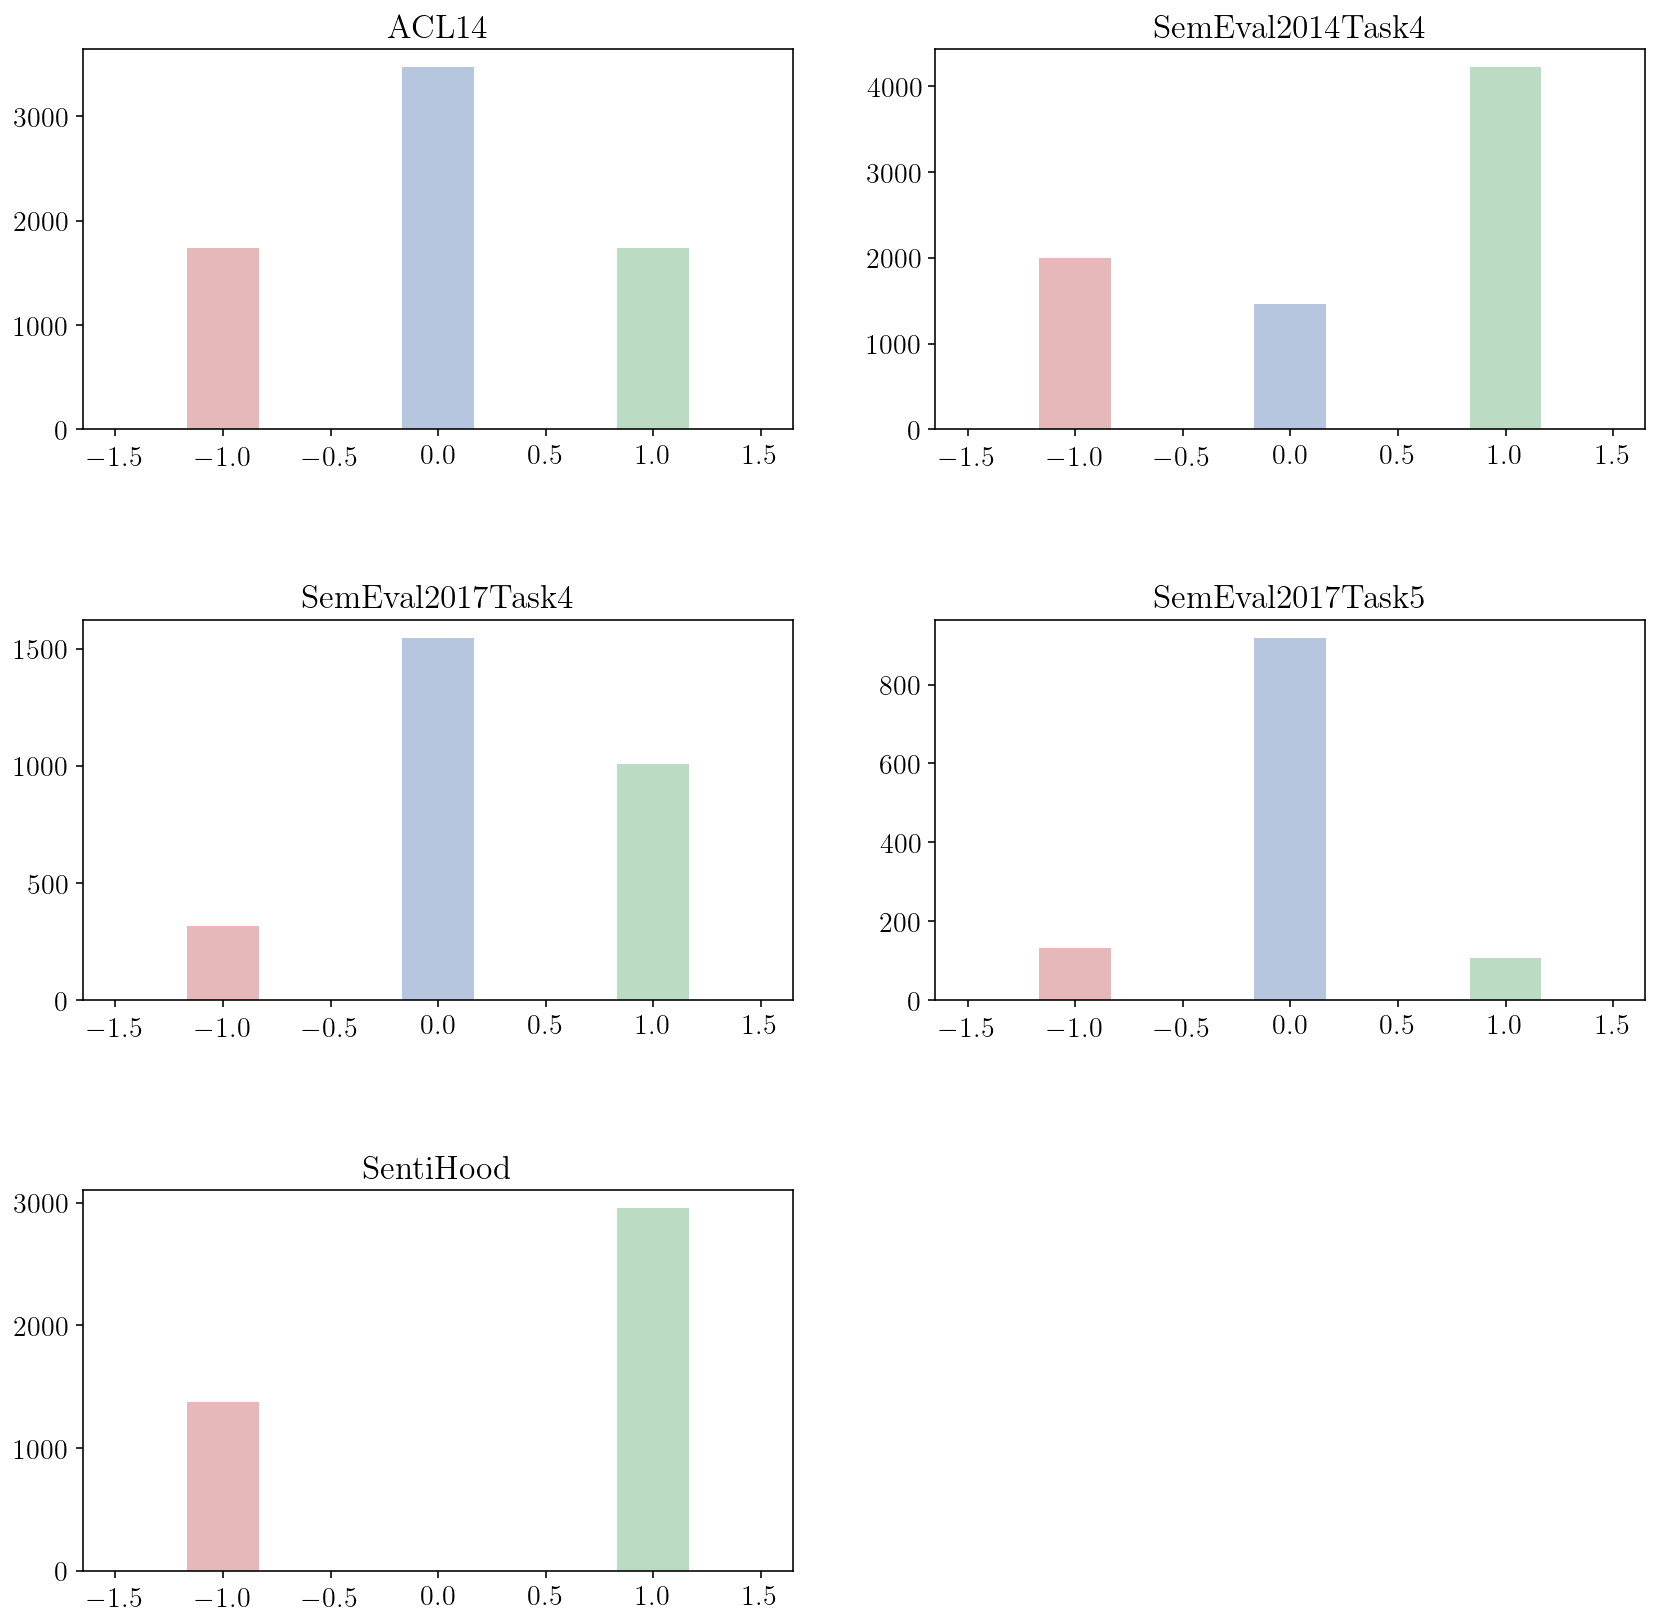

[['ACL14', 6940, 89.17, 10, 161, 0.32, 2214], ['SemEval2014Task4', 7694, 93.68, 8, 470, 0.29, 2207], ['SemEval2017Task4', 2872, 104.13, 26, 144, 0.37, 1060], ['SemEval2017Task5', 1156, 56.54, 25, 112, 0.04, 48], ['SentiHood', 4333, 77.48, 7, 564, 0.15, 658]]


In [322]:
combined_train = []
combined_test = []
comb_train_path = os.path.join(store_path, "COMBINED_train.seg")
comb_test_path = os.path.join(store_path, "COMBINED_test.seg")

ALL_DFS = []

SAVE = False

stats = []
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.subplots_adjust(hspace=0.5)
fig.set_size_inches(14, 14)
#fig.subtitle('Sentiment polarity distribution')
axes = axes.flatten()
sns.set_color_codes()

print(axes)

for ax in axes:
    if ax == axes[-1]:
        ax.axis('off')

data_count = 0
for folder in datasets:
    if "formatted" in folder:
        continue  # this is the output files
    formatted_train = []
    formatted_test = []
    
    out_train = os.path.join(store_path, "{}_train.seg".format(folder))
    out_test = os.path.join(store_path, "{}_test.seg".format(folder))
    
    parser = None  # a parser that takes a data stream as input
    if "ACL" in folder or "SemEval2014" in folder:
        parser = parse_3line_format
    elif "SemEval2017Task4" in folder:
        parser = parse_txt_format
    elif "SemEval2017Task5" in folder:
        parser = parse_json
    elif "SentiHood" in folder:
        parser = parse_json_sentihood
    
    print(folder)
    print(out_train)
    for datatype, data in folder_files(folder).items():
        # there are two options for datatype: [test, train]
        is_train = "train" in datatype
        out_file = out_train if is_train else out_test
        
        for dataset in data:
            print(dataset)
            with open(dataset, 'r', encoding="utf8") as f:
                data = parser(f)                    
                if is_train:
                    formatted_train.extend(data)
                else:
                    formatted_test.extend(data)
    # iterate the datasets, and write to file

    if SAVE:
        if formatted_train != []:
            combined_train.extend(formatted_train)
            write_data(out_train, formatted_train)
        if formatted_test != []:
            combined_test.extend(formatted_test)
            write_data(out_test, formatted_test)
    else:
        # illustrate as dataframes:
        columns = ["text", "entity", "sentiment"]
        folder_data = formatted_train
        folder_data.extend(formatted_test)
        
        df = pd.DataFrame(folder_data, columns=columns)
        df = augment(df, coref=True)
        # visualize(df, folder)
        #show_sentiment(df, folder)
        neg_data = np.array(df.loc[df["sentiment"] == -1].sentiment)
        neu_data = np.array(df.loc[df["sentiment"] == 0].sentiment)
        pos_data = np.array(df.loc[df["sentiment"] == 1].sentiment)
        sent_data = np.array([neg_data, neu_data, pos_data])
        ax = axes[data_count]
        sns.distplot(neg_data, ax=ax, bins=3, kde=False, color="r")
        sns.distplot(neu_data, ax=ax, bins=3, kde=False, color="b")
        sns.distplot(pos_data, ax=ax, bins=3, kde=False, color="g")
        ax.set(title=folder)
        data_count += 1
        ALL_DFS.append(df)

        stats.append(get_df_stats(df, folder))
plt.show()
filename = "sentiment_dist.png"
#plt.savefig(filename, dpi=300, transparent=True)


if SAVE:
    write_data(comb_train_path, combined_train)
    write_data(comb_test_path, combined_test)
    
print(stats)

In [309]:
stats_df = pd.DataFrame(stats, columns=["Dataset", "Ndocs", "Avg doc len", "Min doc len", "Max doc len", "Avg coreference clusters", "Total clusters"])

In [310]:
stats_df

,Dataset,Ndocs,Avg doc len,Min doc len,Max doc len,Avg coreference clusters,Total clusters
0,ACL14,6940,89.17,10,161,0.32,2214
1,SemEval2014Task4,7694,93.68,8,470,0.29,2207
2,SemEval2017Task4,2872,104.13,26,144,0.37,1060
3,SemEval2017Task5,1156,56.54,25,112,0.04,48
4,SentiHood,4333,77.48,7,564,0.15,658


In [311]:
df

,text,entity,sentiment,text_length,coref_clusters
0,$T$ is just a normal area that happens to have...,LOCATION1,1,68,0
1,", $T$ , LOCATION2 are all good places to stay ...",LOCATION1,1,101,0
2,", LOCATION1 , $T$ are all good places to stay ...",LOCATION2,1,101,0
3,A Brazilian man was shot there 3 years ago in ...,LOCATION1,-1,145,1
4,A friend of mine lived in $T$ and she liked it...,LOCATION1,1,97,1
...,...,...,...,...,...
4328,you also have really nice areas like LOCATION2...,LOCATION1,1,54,0
4329,you also have really nice areas like $T$ and L...,LOCATION2,1,54,0
4330,"you could also try $T$ , tho its certainly a b...",LOCATION1,-1,60,0
4331,you could get the train to $T$ station,LOCATION1,1,38,0


In [320]:
length_batches = [(0, 30), (30, 60), (60, 90), (90, 120), (120, 150), (150, 180), (180, 999)]
start = 0
length_batches = [(i, i+30) for i in range(0, 300, 30)]
#neg_data = np.array(df.loc[df["sentiment"] == -1].sentiment)
txt = df["text_length"]
for lb in length_batches:
    mi, ma = lb
    lb_df = df.loc[(df["text_length"] > mi) & (df["text_length"] < ma)]
    corefs = sum(np.array(lb_df["coref_clusters"]))
    print(lb, corefs)
    #print(lb_df.head())

(0, 30) 4
(30, 60) 77
(60, 90) 174
(90, 120) 176
(120, 150) 97
(150, 180) 50
(180, 210) 20
(210, 240) 12
(240, 270) 7
(270, 300) 8
